# Part 2, Topic 2: Introduction to Voltage Glitching (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *While it's not as sophisticated as the ChipWhisperer Lite or ChipWhisperer Pro's glitch hardware, the ChipWhisperer Nano is also capable of glitching. In this lab, we'll do some simple glitch tests on the Nano's target board, showing how to scan through glitch settings and seeing what effect it has on the hardware.*

**LEARNING OUTCOMES:**

* Understanding how voltage glitching can be used to disrupt a target's operation
* Scanning glitch settings to determine successful ones

Digital hardware devices have certain voltage and clock requirements to function properly. If these requirements are not met, the device can fail to function, or even be damage. By shorting the voltage pins of a microcontroller for controlled, short periods of time, we can cause it to behave erratically, clearning registers and skipping instructions.  Such attacks can be immensely powerful in practice. Consider for example the following code from `linux-util-2.24`:

```C
/*
 *   auth.c -- PAM authorization code, common between chsh and chfn
 *   (c) 2012 by Cody Maloney <cmaloney@theoreticalchaos.com>
 *
 *   this program is free software.  you can redistribute it and
 *   modify it under the terms of the gnu general public license.
 *   there is no warranty.
 *
 */

#include "auth.h"
#include "pamfail.h"

int auth_pam(const char *service_name, uid_t uid, const char *username)
{
    if (uid != 0) {
        pam_handle_t *pamh = NULL;
        struct pam_conv conv = { misc_conv, NULL };
        int retcode;

        retcode = pam_start(service_name, username, &conv, &pamh);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_authenticate(pamh, 0);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_acct_mgmt(pamh, 0);
        if (retcode == PAM_NEW_AUTHTOK_REQD)
            retcode =
                pam_chauthtok(pamh, PAM_CHANGE_EXPIRED_AUTHTOK);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_setcred(pamh, 0);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        pam_end(pamh, 0);
        /* no need to establish a session; this isn't a
         * session-oriented activity...  */
    }
    return TRUE;
}
```

This is the login code for the Linux OS. Note that if we could skip the check of `if (uid != 0)` and simply branch to the end, we could avoid having to enter a password. This is the power of glitch attacks - not that we are breaking encryption, but simply bypassing the entire authentication module! 

### Glitch Hardware

The ChipWhisperer Nano's glitch setup is pretty simple. Like its bigger brothers, the Lite and the Pro, it uses a MOSFET to short the microcontroller's voltage supply to ground:

![](https://wiki.newae.com/images/8/82/Glitch-vccglitcher.png)

For the Nano, `Glitch In` is controlled by 2 parameters:

1. `scope.glitch.ext_offset` - The glitch will be inserted roughly `8.3ns * scope.glitch.ext_offset`
1. `scope.glitch.repeat`     - The glitch will be inserted for roughly `8.3ns * scope.glitch.repeat`

During this lab, we'll be varying these parameters to see if we can get the target to mess up a calculation that it's doing.

In [160]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
SS_VER = 'SS_VER_2_1'

In [161]:
import chipwhisperer as cw

In [176]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

(ChipWhisperer NAEUSB WARNING|File naeusb.py:826) Your firmware (0.65.0) is outdated - latest is 0.66.0 See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
INFO: Found ChipWhisperer😍


In [163]:
%%bash -s "$PLATFORM" "$SS_VER"
cd ../../../firmware/mcu/simpleserial-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$2 -j

SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
arm-none-eabi-gcc (Arm GNU Toolchain 14.2.Rel1 (Build arm-14.52)) 14.2.1 20241119
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWNANO 
.
Welcome to another exciting ChipWhisperer target build!!
.
.
.
.
.
.
Compiling:
Compiling:
Compiling:
Compiling:
Assembling: .././hal//stm32f0/stm32f0_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CWNANO/stm32f0_startup.lst -I.././simpleserial/ -I.././hal/ -I.././hal/ -I.././hal//stm32f0 -I.././hal//stm32f0/CMSIS -I.././hal//stm32f0/CMSIS/core -I.././hal//stm32f0/CMSIS/device -I.././hal//stm32f0/Legacy -I.././simpleserial/ -I.././crypto/ .././hal//stm32f0/stm32f0_startup.S -o objdir-CWNANO/stm32f0_startup.o
Compiling:
-

/Applications/ArmGNUToolchain/14.2.rel1/arm-none-eabi/bin/../lib/gcc/arm-none-eabi/14.2.1/../../../../arm-none-eabi/bin/ld: warning: simpleserial-glitch-CWNANO.elf has a LOAD segment with RWX permissions


Memory region         Used Size  Region Size  %age Used
             RAM:        1560 B         4 KB     38.09%
             ROM:        6016 B        32 KB     18.36%
-e Done!
.
.
.
.
.
Creating load file for Flash: simpleserial-glitch-CWNANO.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature simpleserial-glitch-CWNANO.elf simpleserial-glitch-CWNANO.hex
Creating load file for Flash: simpleserial-glitch-CWNANO.bin
arm-none-eabi-objcopy -O binary -R .eeprom -R .fuse -R .lock -R .signature simpleserial-glitch-CWNANO.elf simpleserial-glitch-CWNANO.bin
Creating Extended Listing: simpleserial-glitch-CWNANO.lss
arm-none-eabi-objdump -h -S -z simpleserial-glitch-CWNANO.elf > simpleserial-glitch-CWNANO.lss
Creating Symbol Table: simpleserial-glitch-CWNANO.sym
arm-none-eabi-nm -n simpleserial-glitch-CWNANO.elf > simpleserial-glitch-CWNANO.sym
Creating load file for EEPROM: simpleserial-glitch-CWNANO.eep
arm-none-eabi-objcopy -j .eeprom --set-section-flags=.eeprom="allo

In [164]:
fw_path = "../../../firmware/mcu/simpleserial-glitch/simpleserial-glitch-{}.hex".format(
    PLATFORM
)

scope: cw.scopes.CWNano
prog: cw.programmers.CWNano
target: cw.targets.SimpleSerial

cw.program_target
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6015 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6015 bytes


In [165]:
import time

scope.io.clkout = 7.5E6
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

print(scope.io.clkout)

7500000.0


In [181]:
import numpy as np

scope.default_setup()
scope.adc.samples = 1000

trace_count = 1000
cmp_trace_sums = {
    'correct': np.zeros(scope.adc.samples),
    'incorrect': np.zeros(scope.adc.samples),
}

for _ in range(trace_count):
    for case in ['correct', 'incorrect']:
        reboot_flush()

        scope.arm()

        if case == 'correct':
            target.simpleserial_write("c", bytearray([0xA2]))
        else:
            target.simpleserial_write("c", bytearray([0x00]))
        
        scope.capture()

        trace = scope.get_last_trace()

        cmp_trace_sums[case] += trace


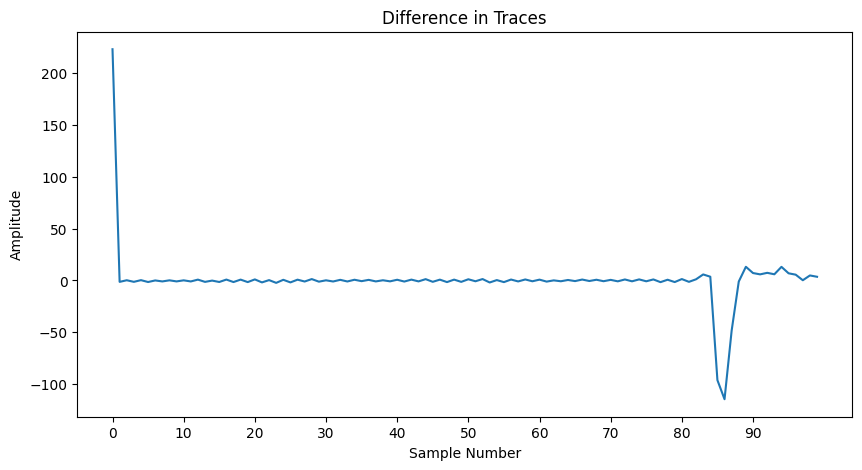

86


In [182]:
import matplotlib.pyplot as plt

diff = cmp_trace_sums["correct"] - cmp_trace_sums["incorrect"]

samples_to_plot = 100

plt.figure(figsize=(10, 5))
plt.plot(diff[:samples_to_plot])
plt.title("Difference in Traces")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, samples_to_plot, 10))
plt.show()

print(np.argmin(diff[:samples_to_plot]))

In [183]:
trace_count = 50
trace_sums = {
    'unglitched': np.zeros(scope.adc.samples),
    'glitched': np.zeros(scope.adc.samples),
}

scope.glitch.ext_offset = 683

for _ in range(trace_count):
    for case in ['unglitched', 'glitched']:
        scope.glitch.repeat = 12 if case == 'glitched' else 0
        # reboot_flush()
        scope.arm()
        target.simpleserial_write('c', bytearray([0x00]))  # runs target’s glitch_loop with trigger_high()
        ret = scope.capture()                          # should succeed (no glitch = no crash)
        if ret:
            print(f"Timeout while waiting for target response")
            continue
        baseline_trace = scope.get_last_trace()         # NumPy array (length = 5000)
        trace_sums[case] += baseline_trace

print(scope.glitch.ext_offset, scope.glitch.repeat)

683 12


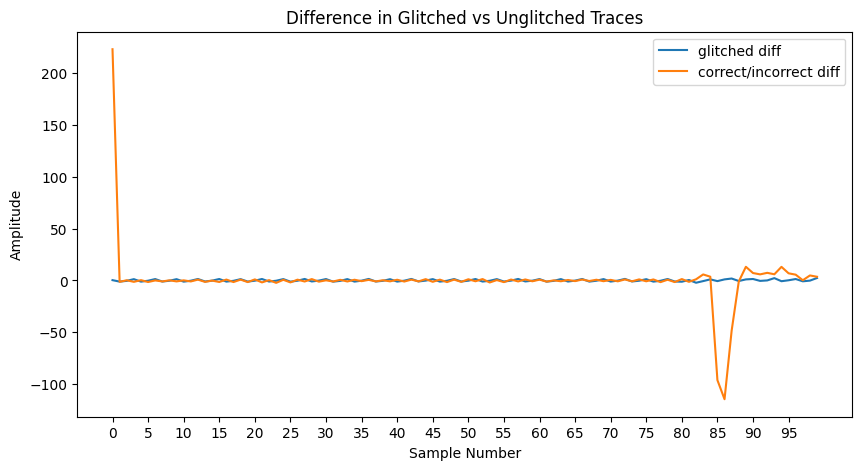

82


In [184]:
trace_diff = np.array(trace_sums["unglitched"] - trace_sums["glitched"])

samples_to_plot = 100
plt.figure(figsize=(10, 5))
plt.plot(trace_diff[:samples_to_plot], label='glitched diff')
plt.title("Difference in Glitched vs Unglitched Traces")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, samples_to_plot, 5))
plt.plot(diff[:samples_to_plot], label='correct/incorrect diff')
plt.legend()
plt.show()
print(np.argmin(trace_diff[:samples_to_plot]))

In [32]:
gc = cw.GlitchController(groups=["success", "reset", "normal"], parameters=["repeat", "ext_offset"])
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='repeat setting:', disabled=True, max=10.0, readou…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

Some tips for finding good glitches:

1. This is a VCC line that we're shorting, so there's going to be stuff fighting against us. If your glitch is too short, it might not have any effect
1. Likewise, if your glitch is too long, the target will always crash. There's typically a small band where you're able to affect the target, but it won't always crash it.
1. Be patient. Glitching can be somewhat inconsistant, so don't be discouraged if it takes a while to see some success!

In [33]:
gc.glitch_plot(plotdots={"success":"+g", "reset":"xr", "normal":None})

BokehModel(combine_events=True, render_bundle={'docs_json': {'7aaebf9d-b50f-46fa-ac42-eefdbf788334': {'version…

In [114]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct

g_step = 1

gc.set_global_step(g_step)
gc.set_range("repeat", 12, 12)
# gc.set_range("ext_offset", 500, 800) # from glitch peak at sample 69 to 87 (glitch at 87)

# success rates
#  652: 0.0033333333333333335,
#  652: 0.0033333333333333335,
#  654: 0.0033333333333333335,
#  655: 0.0033333333333333335,
#  675: 0.0033333333333333335,
#  679: 0.02,
#  680: 0.013333333333333334,
#  682: 0.03,
#  683: 0.14,
#  687: 0.0033333333333333335

gc.set_range("ext_offset", 680, 685)

reboot_flush()
sample_size = 1
for glitch_setting in gc.glitch_values():
    scope.glitch.repeat = glitch_setting[0]
    scope.glitch.ext_offset = glitch_setting[1]
    successes = 0
    resets = 0
    
    for i in range(300):
        target.flush()
            
        scope.arm()
        
        target.simpleserial_write("c", bytearray([0x00]))
        
        ret = scope.capture()
        
        val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)

        if ret:
            print('Timeout - no trigger')
            gc.add("reset")
            resets += 1

            #Device is slow to boot?
            reboot_flush()

        else:
            if val['valid'] is False:
                reboot_flush()
                gc.add("reset")
                resets += 1
            else:
                if val['payload'][0] == 1:
                    gc.add("success")
                    successes += 1
                else:
                    gc.add("normal")

    if successes > 0:                
        print("successes = {}, resets = {}, repeat = {}, ext_offset = {}".format(successes, resets, scope.glitch.repeat, scope.glitch.ext_offset))
        
print("Done glitching")


(ChipWhisperer Target WARNING|File SimpleSerial2.py:381) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:414) Unexpected length 69, 1
(ChipWhisperer Target WARNING|File SimpleSerial2.py:381) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:414) Unexpected length 69, 1
(ChipWhisperer Target WARNING|File SimpleSerial2.py:381) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:414) Unexpected length 69, 1
(ChipWhisperer Target WARNING|File SimpleSerial2.py:381) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:414) Unexpected length 69, 1
(ChipWhisperer Target WARNING|File SimpleSerial2.py:381) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:414) Unexpected length 69, 1
(ChipWhisperer Target WARNING|File SimpleSerial2.py:381) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:414) Unexpected

KeyboardInterrupt: 

In [113]:
gc: glitch.GlitchController

# (12, 675): {'total': 300,
#   'success': 1,
#   'success_rate': 0.0033333333333333335,
#   'reset': 31,
#   'reset_rate': 0.10333333333333333,
#   'normal': 268,
#   'normal_rate': 0.8933333333333333},

results: dict[tuple[int, int], dict[str, float]] = gc.results.calc()

filtered_results = {k: v for k, v in results.items() if v['success_rate'] > 0}
# filtered_results = {k[1]: v['success_rate'] for k, v in filtered_results.items()}

filtered_results


{}

In [84]:
gc.plot_2d(alpha=False)

[0, 1]
['repeat', 'ext_offset']
(12, 682)


:Overlay
   .Points.I       :Points   [Repeat,Ext_Offset]
   .Points.Success :Points   [repeat,ext_offset]   (success_rate)
   .Points.Reset   :Points   [repeat,ext_offset]   (reset_rate)

In [35]:
scope.dis()
target.dis()

Unlike the other ChipWhisperers, the Nano doesn't have sychronous glitching. This means that `ext_offset` is a mixture of both the offset within the clock cycle, which affects glitch success, and ext_offset, which affects which instruction is being glitched. As such, ext_offset settings you find in this lab won't be directly applicable to other labs. That being said, good ranges for repeat and the success rate of glitches still gives valuable information that you can apply to other labs.